# Histopathologic cancer detection | Kaggle challenge

The [Kaggle cancer detection challenge](https://www.kaggle.com/c/histopathologic-cancer-detection) asks contestants to develop algorithms to classify histopathologic cancer images. The contestants are provided with over 250,000 images from the [PatchCamelyon dataset](https://github.com/basveeling/pcam). The 96$\times$96 large microscopy images of stained lymph node biopsy samples are labelled according to whether their central 32$\times$32 pixel large region includes at least one pixel of cancerous tissue.

The challenge appealed to me due to the relatively small image size allowing me to iterate through different algorithms and approaches relatively quickly. In particular, my goals were:
- To code and train a convolutional neural network from scratch without simply loading a pre-trained model.
- To implement basic data augmentation and observe its impact.
- To explore model ensembling and its benefits.
- Score reasonably well with these modest tools. I placed less emphasis on exploring all of the largest and newest CNN architectures.

## Import libraries

The code presented in this notebook was run on a desktop computer (Intel i5-6500 CPU, 16GB Ram, NVIDIA GeForce GTX 1070).<br/>
It was written in Python 3.6 relying on the following packages:
- cudnn 7.1.4 for CUDA 9.0
- Keras 2.2.4
- TensorFlow 1.12.0 as backend to Keras
- matplotlib 3.0.2
- NumPy 2.1.4
- Pandas 0.23.4
- Scikit-image 0.14.1
- Scikit-learn 0.20.2
- Seaborn 0.9.0

In [26]:
from keras.backend.tensorflow_backend import set_session
from keras.models import Model, load_model
from keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, Dropout
from keras.layers import Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.utils import Sequence
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from sklearn import metrics, model_selection
import seaborn as sns

## Data preparation
### Data import
A list of image identifiers is saved. Each entry corresponds to a filename of a learning or test image. For the learning images, labels are provided as well. They denote either the presence (1) or absence (0) of tumor cells in the central region. These labels are saved as dictionary with the image identifier as key. The training and validation split is done later during model training. Limited memory size prohibits me from loading and storing all images at once. Instead, a data generator is defined later allowing me to load the images at run time. 

In [11]:
learning_directory = './Data/train'
learning_data = pd.read_csv('./Data/train_labels.csv')
learning_identifier = learning_data.id.tolist()
learning_labels = learning_data.set_index('id').label.to_dict()
n_learning = len(learning_identifier)

test_directory = './Data/test'
test_data = pd.read_csv('./Data/sample_submission.csv')
test_identifier = test_data.id.tolist()
n_test = len(test_identifier)

### Display 10 random examples

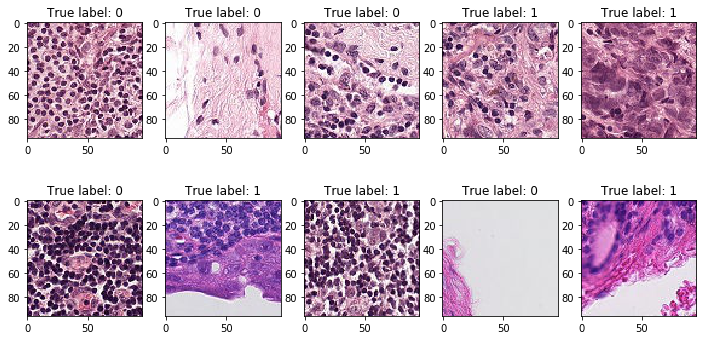

In [12]:
random_examples = np.random.choice(learning_identifier, 10)

fig = plt.figure(figsize=(12, 6))
subfigure = 1

for example in random_examples:
    fig.add_subplot(2, 5, subfigure)
    subfigure += 1
    
    filepath = learning_directory + '/' + str(example) + '.tif'    
    image = io.imread(filepath, plugin='tifffile')
    
    plt.imshow(image)
    plt.title('True label: ' + str(learning_labels[example]))

### Display ratio of labels

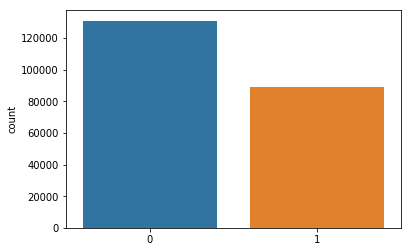

In [13]:
sns.countplot(data=pd.Series(learning_labels), x=learning_labels)

## DataGenerator
This data generator runs on the CPU and feeds in training or test images to the neural network eliminating the need to load all images to memory beforehand. The code is adapted from [this blog post](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) by Afshine and Shervine Amidi. I have implemented some minor fixes in the `__data_generation` function. Additionally, the data generator was extended to facilitate data augmentation. The image can be manipulated using one of seven different transformations or return the image as is. I did not use any translation augmentations as the central region would change. Also, I was not sure about natural color variations of the used microscopy stain, so I omitted these augmentation method as well.

In [14]:
class DataGenerator(Sequence):
    def __init__(self, directory, identifier, labels, batch_size=32, shuffle=False, shuffle_augment=False, specific_augmentation=0):
        self.directory = directory
        self.identifier = identifier
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shuffle_augment = shuffle_augment
        self.specific_augmentation = specific_augmentation
        
        self.indices = np.arange(len(identifier))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.identifier) / self.batch_size))

    def __getitem__(self, index):
        selected_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        selected_identifier = [self.identifier[k] for k in selected_indices]

        X, y = self.__data_generation(selected_identifier)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __data_generation(self, selected_identifier):
        X = np.empty((len(selected_identifier),96,96,3))
        y = np.empty(len(selected_identifier), dtype=int)
        if self.shuffle_augment:
            numberOfPossibleAugmentations = 8
            augmentations = np.random.randint(numberOfPossibleAugmentations, size=len(selected_identifier))
        else:
            augmentations = np.ones(len(selected_identifier), dtype=int) * self.specific_augmentation

        for i, temp_identifier in enumerate(selected_identifier):
            X[i,] = self.__get_image(self.directory, temp_identifier, augmentations[i])
            if temp_identifier in self.labels:
                y[i] = self.labels[temp_identifier]
            else:
                y[i] = -1
                
        return X, y
    
    def __get_image(self, directory, identifier, augmentation):
        filepath = directory + '/' + str(identifier) + '.tif'    
        image = io.imread(filepath, plugin='tifffile') / 255

        if augmentation == 0:
            return image # do not augment
        elif augmentation == 1:
            return np.rot90(image, k=1, axes=(0, 1)) # rotate 90 degrees counterclockwise
        elif augmentation == 2:
            return np.rot90(image, k=2, axes=(0, 1)) # rotate 180 degrees
        elif augmentation == 3:
            return np.rot90(image, k=3, axes=(0, 1)) # rotate 90 degrees clockwise
        elif augmentation == 4:
            return np.fliplr(image) # mirror image along vertical axis
        elif augmentation == 5:
            return np.rot90(np.fliplr(image), k=1, axes=(0, 1)) # mirror image then rotate 90 degrees counterclockwise
        elif augmentation == 6:
            return np.rot90(np.fliplr(image), k=2, axes=(0, 1)) # mirror image then rotate 180 degrees clockwise
        elif augmentation == 7:
            return np.rot90(np.fliplr(image), k=3, axes=(0, 1)) # mirror image then rotate 90 degrees clockwise

## CNN architecture selection

I explored several different CNN architectures. I spend the most time using the following two: 
- The first architecture *SimpleCNN* is a modified version of the [CNN example described in the keras documentation](https://keras.io/examples/cifar10_cnn/). It was extended by an additional set of two 3$\times$3 Conv2D and one MaxPooling layer.
- The *ResNet* architecture, which won the ILSVRC 2015 classification task challenge, is adapted from [this paper](https://arxiv.org/abs/1512.03385) by He *et al.* Compared to their implementation, I have omitted the very first MaxPooling Layer as our images are substantially smaller than the 224$\times$224 pixel large images used in the ImageNet challenge. The paper specifies different sizes of networks and I spend the most size using the versions with 18 and 50 convolutional layers as well as a derived version with 9 layers. 

In [28]:
def SimpleCNN():
    inputs = Input(shape=(96,96,3,))

    x = Conv2D(filters=32, kernel_size=(3,3), padding='valid')(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3,3), padding='valid')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=64, kernel_size=(3,3), padding='valid')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), padding='valid')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=0.25)(x)

    x = Conv2D(filters=128, kernel_size=(3,3), padding='valid')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='valid')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(rate=0.25)(x)
    
    x = Flatten()(x)
    x = Dense(units=512)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=1)(x)
    outputs = Activation('sigmoid')(x)
    
    return Model(inputs=inputs, outputs=outputs)


def ResNet18():
    inputs = Input(shape=(96,96,3,))
    
    # Stage 1
    x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    # Stage 2
    x_shortcut = x
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Stage 3
    x_shortcut = x
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Stage 4
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Stage 5
    x_shortcut = x
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=512, kernel_size=(1,1), strides=(2,2), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=1)(x)
    outputs = Activation('sigmoid')(x)
    
    return Model(inputs=inputs, outputs=outputs)

## Putting things together
In these test grounds, the components are put together and tweaked. I am not presenting all iterations this notebook has gone through. The main steps I traversed were:

- Initially, I used the SimpleCNN architecture to test whether the data generator and image augmentation were working as inteded.


- I was surprised how well the architecture already scored considering the relatively simple architecture and that an entire epoch of training ran in less than four minutes.


- Additionally, I used SimpleCNN to investigate the impact of input image size. Even though only a ninth of the image is supposed to be considered for labelling, using the entire image increases the prediction accuracy. Intuitively, this is not very surprising as the CNN can easily represent the fact that only the central region is relevant and the cell type found in the outer regions probably strongly correlates with the type in the image center.


- Moving to the ResNet18 architecture, I spend some time trying to figure out why my validation error fluctuated substantially during the initial epochs. I had to read up on batch normalization once again and found that decreasing the momentum of the batch normalization layers from the default value of 0.99 greatly reduced the number of epochs needed to accurately predict on the validation set. While this helped during my (impatient) prototyping, it will ultimately slightly increase the generalization error as the beta and gamme values of the batch normalization layers now depend more strongly on the most recent training examples.


- Additionally, I substantially improved the training and validation accuracy by adapting the learning rate, both initially as well as over the course of training as validation error plateaus. I did not find a reason to move away from the reliable Adam optimizer.


- In order to run the larger ResNet50 architecture on my GPU, I had to reduce the batch size from 256 to 32. Training one, let alone multiple, networks on my desktop computer is quite tedious and I have not experimented all too much with this larger network architecture.


- For a couple of well-performing model architectures and training approaches, I deployed model ensembling as an relatively simple way to improve my final test accuracy. Two different ensembling techniques were used: I train five different models on five non-overlapping folds of the learning data. Additionally, I use all eight implemented image augmentations at test time. Ultimately, the final prediction for each test image is the mean of these 40 individual predictions.


- On Kaggle, the accuracy of the predictions is assessed using the area under the receiver operating characteristic curve (AUC) score and, ideally, this metric would be used as loss to optimize the networks. However, AUC can fluctuate substantially for small minibatch sizes and is not easily differentiable. For this reason, I stuck with log loss, which I found to strongly correlate with the AUC score anyways.


### Model test grounds

In [21]:
# Define input data and create data generators
training_identifier, validation_identifier = model_selection.train_test_split(learning_identifier, train_size=0.8,
                                                                              test_size=0.2, shuffle=True)

training_generator = DataGenerator(learning_directory, training_identifier, learning_labels,
                               batch_size=256, shuffle=True, shuffle_augment=True)
validation_generator = DataGenerator(learning_directory, validation_identifier, learning_labels,
                                 batch_size=256, shuffle=False, shuffle_augment=False)

# Build model and create callbacks
model = SimpleCNN()
optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

save_best_model = ModelCheckpoint(filepath='./Test_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
adapt_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

# Train and save model
model.fit_generator(generator=training_generator, validation_data=validation_generator,
                    epochs=60, callbacks=[save_best_model, adapt_learning_rate], workers=4)

### Model ensembling for final predictions

In [ ]:
splitter = model_selection.KFold(n_splits=5, shuffle=True)

model_counter = 0
model_names = []

for training_indices, validation_indices in splitter.split(learning_identifier):
    model_counter += 1
    model_name = 'Model_' + str(model_counter)
    print('Training' + model_name)
    
    # Define input data and create data generators
    training_identifier = [learning_identifier[i] for i in training_indices]
    validation_identifier = [learning_identifier[i] for i in validation_indices]
    
    training_generator = DataGenerator(learning_directory, training_identifier, learning_labels,
                                   batch_size=256, shuffle=True, shuffle_augment=True)
    validation_generator = DataGenerator(learning_directory, validation_identifier, learning_labels,
                                     batch_size=256, shuffle=False, shuffle_augment=False)
    
    # Build model and create callbacks
    model = ResNet18()
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    save_path = './' + model_name + '.h5'
    save_best_model = ModelCheckpoint(filepath=save_path, monitor='val_loss', verbose=1, save_best_only=True)
    adapt_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

    # Train and save model
    model.fit_generator(generator=training_generator, validation_data=validation_generator,
                        epochs=60, callbacks=[save_best_model, adapt_learning_rate], workers=4)

In [ ]:
noPossibleAugmentations = 8
predictions = np.zeros((len(test_identifier), len(model_names), noPossibleAugmentations))

for i, model_name in enumerate(model_names):
    model = load_model('./' + model_name + '.h5')
    
    for specific_augmentation in range(noPossibleAugmentations):
        test_generator = DataGenerator(test_directory, test_identifier, {},
                                       batch_size=1024, shuffle=False, shuffle_augment=False,
                                       specific_augmentation=specific_augmentation)

        prediction = model.predict_generator(generator=test_generator, workers=4, verbose=1)
        predictions[:,i,specific_augmentation] = prediction.ravel()

final_predictions = predictions.mean(axis=(1,2))
submission = pd.DataFrame({'id' : test_identifier, 'label' : final_predictions})
submission.to_csv('./submission_file.csv', index=False)

## Final results:
Placeholder

## Appendix: Code for ResNet50 architecture

In [ ]:
def ResNet50():
    inputs = Input(shape=(96,96,3,))
    
    # Stage 1
    x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    # Stage 2
    x_shortcut = x
    x = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Stage 3
    x_shortcut = x
    x = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=512, kernel_size=(1,1), strides=(2,2), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Stage 4
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=1024, kernel_size=(1,1), strides=(2,2), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1024, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Stage 5
    x_shortcut = x
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(2,2), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=2048, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x_shortcut = Conv2D(filters=2048, kernel_size=(1,1), strides=(2,2), padding='same')(x_shortcut)
    x_shortcut = BatchNormalization(momentum=0.9)(x_shortcut)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=2048, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    x_shortcut = x
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=2048, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    # Output
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=1)(x)
    outputs = Activation('sigmoid')(x)
    
    return Model(inputs=inputs, outputs=outputs)